In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Support package for data cleaning
import support.cleaning_pipe as cp


Note: Every random state is used is from random.randint to maintain randomness.  It will be explicitly written though, to maintain reproducibility

In [2]:
df = pd.read_csv(os.path.join('..', 'data', 'rookies_stats.csv'))
stats_desc = pd.read_csv(os.path.join('..', 'data', 'rookies_stats_desc.csv'), index_col='feature')

df.head()

,rk,player,debut,age,yrs,g,mp,fg,fga,threes,...,pts,fg_pct,threes_pct,ft_pct,mp_pg,pts_pg,trb_pg,ast_pg,yr1,retired
0,1,Rafer Alston,"Feb 17, '00, MIL vs. IND",23,11,27,361,27,95,3,...,60,0.284,0.214,0.750,13.4,2.2,0.9,2.6,2000,1
1,2,Chucky Atkins,"Nov 2, '99, ORL @ CHH",25,11,82,1626,314,741,57,...,782,0.424,0.350,0.729,19.8,9.5,1.5,3.7,2000,1
2,3,William Avery,"Nov 13, '99, MIN vs. PHO",20,3,59,484,56,181,18,...,154,0.309,0.286,0.667,8.2,2.6,0.7,1.5,2000,1
3,4,Jonathan Bender,"Dec 10, '99, IND vs. CLE",19,8,24,130,23,70,2,...,64,0.329,0.167,0.667,5.4,2.7,0.9,0.1,2000,1
4,5,Calvin Booth,"Mar 25, '00, WAS @ DAL",23,10,11,143,16,46,0,...,42,0.348,0.000,0.714,13.0,3.8,2.9,0.6,2000,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rk          1051 non-null   int64  
 1   player      1051 non-null   object 
 2   debut       1051 non-null   object 
 3   age         1051 non-null   int64  
 4   yrs         1051 non-null   int64  
 5   g           1051 non-null   int64  
 6   mp          1051 non-null   int64  
 7   fg          1051 non-null   int64  
 8   fga         1051 non-null   int64  
 9   threes      1051 non-null   int64  
 10  threes_a    1051 non-null   int64  
 11  ft          1051 non-null   int64  
 12  fta         1051 non-null   int64  
 13  orb         1051 non-null   int64  
 14  trb         1051 non-null   int64  
 15  ast         1051 non-null   int64  
 16  stl         1051 non-null   int64  
 17  blk         1051 non-null   int64  
 18  tov         1051 non-null   int64  
 19  pf          1051 non-null  

In [4]:
def get_desc(feature):
    '''This method takes a feature name and returns its description'''
    print(f"{feature}: {stats_desc['description'][feature]}")

## Notes for Data Preparation:
- Convert: These values should be listed in terms of per minute, to show the efficiency of the player on the court
    - 'fg'
    - 'threes'
    - 'ft'
    - 'orb'
    - 'trb'
    - 'ast'
    - 'stl'
    - 'blk'
    - 'tov'
    - 'pf'
    - 'pts'
- Drop: These values should be dropped because they are redundant.
    - 'mp_pg': We have minutes played and games played
    - 'fga': We have field goals made (now converted to a per minute basis) and its percentage
    - 'threes_a': We have three pointers made (now converted to a per minute basis) and its percentage
    - 'fta': We have free throws made (now converted to a per minute basis) and its percentage
    - 'trb_pg': We have total rebounds (now converted to a per minute basis) and games played
    - 'ast_pg': We have assist (now converted to a per minute basis) and games played
    - 'pts_pg': We have points made (now converted to a per minute basis) and games played
    - 'yr1' is useful info, just to know when they started, but it's not useful information for determining if someone will have a career of at least 5 years
    - 'retired' is important to consider when looking at players that have not yet hit a 5 year career.  Not applicable here
- Clean:
    - 'debut' is their first game.  We could see if the month their debut has any impact, but I doubt it would be important.  We can check anyways.  Order the months by start to end of season, not calendar
    - 'yrs' is the number of seasons they have played.  This is basically a label ( >/< 5 yrs).  It needs to be turned into the label we need
    - A lot of these stats should be put into a per game basis before continuing, because a lot of information will be drowned out by players that had more time on the court
    - Another thing to do is scaling the values.  I would want to explore the data before scaling though
- Other:
    - 'player' is just their name.  We should not have it in any analyses, but we want to hold on to it, in case we want to know their names

In [5]:
to_pm = ['fg', 'threes', 'ft', 'orb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
drop_cols = ['mp_pg', 'fga', 'threes_a', 'fta', 'trb_pg', 'ast_pg', 'pts_pg', 'yr1', 'retired']
min_seasons = 5

cleaning_pipe = Pipeline([
    ("to_per_minute", cp.ToPerMinute(to_pm)),
    ("drop_columns", cp.DropFeatures(drop_cols)),
    ("get_month", cp.GetDebutMonth()),
    ("create_labels", cp.CreateLabels(min_seasons))
])

In [6]:
df_prepped = cleaning_pipe.fit_transform(df)
df_prepped.head()

,rk,player,debut,age,g,mp,fg_pct,threes_pct,ft_pct,fg_pm,...,ft_pm,orb_pm,trb_pm,ast_pm,stl_pm,blk_pm,tov_pm,pf_pm,pts_pm,lasts
0,1,Rafer Alston,4,23,27,361,0.284,0.214,0.750,0.07479,...,0.00831,0.01385,0.06371,0.19391,0.03324,0.00000,0.08033,0.08033,0.16620,True
1,2,Chucky Atkins,1,25,82,1626,0.424,0.350,0.729,0.19311,...,0.05966,0.01230,0.07749,0.18819,0.03198,0.00185,0.08733,0.08426,0.48093,True
2,3,William Avery,1,20,59,484,0.309,0.286,0.667,0.11570,...,0.04959,0.01653,0.08264,0.18182,0.02893,0.00413,0.08678,0.12397,0.31818,False
3,4,Jonathan Bender,2,19,24,130,0.329,0.167,0.667,0.17692,...,0.12308,0.03077,0.16154,0.02308,0.00769,0.03846,0.05385,0.13846,0.49231,True
4,5,Calvin Booth,5,23,11,143,0.348,0.000,0.714,0.11189,...,0.06993,0.10490,0.22378,0.04895,0.02098,0.09790,0.04196,0.16084,0.29371,True


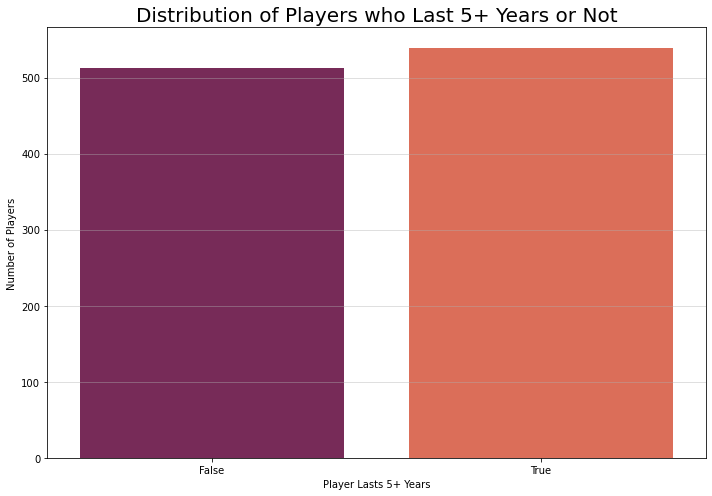

In [7]:
plt.figure(figsize=(10, 7))
sns.countplot(data=df_prepped, x='lasts', palette='rocket')
plt.title("Distribution of Players who Last 5+ Years or Not", size=20)
plt.xlabel('Player Lasts 5+ Years')
plt.ylabel('Number of Players')
plt.grid(axis='y', alpha=.5)
plt.tight_layout()
plt.show()

This is pretty evenly distributed.  This shows that there is a very high attrition rate in the NBA, but for our purposes, this means that we will not have to worry about poor distribution of class labels.

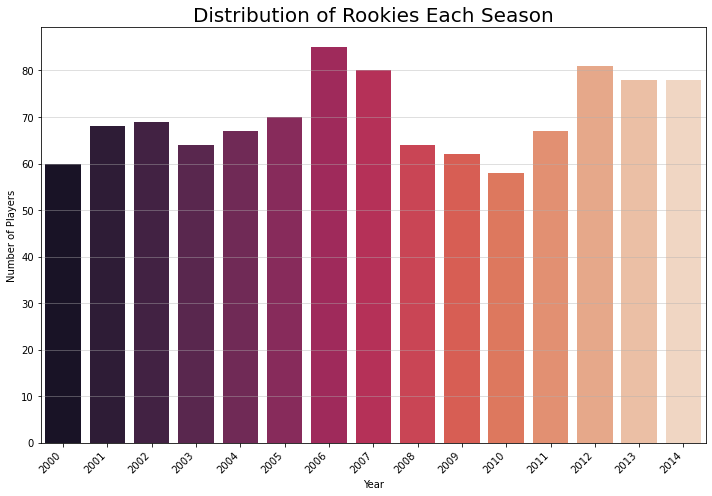

In [8]:
season_count = df.groupby(['yr1'])['yr1'].count()

plt.figure(figsize=(10, 7))
sns.countplot(data=df, x='yr1', palette='rocket')
plt.title('Distribution of Rookies Each Season', size=20)
plt.xticks(rotation=45, horizontalalignment='right')
plt.xlabel('Year')
plt.ylabel('Number of Players')
plt.grid(axis='y', alpha=.5)
plt.tight_layout()
plt.show()

So this shows that they don't just recruit the same number of players each year, they recruit according to need.  This really doesn't have much variation to it, the number of rookies added each season is roughly equal.

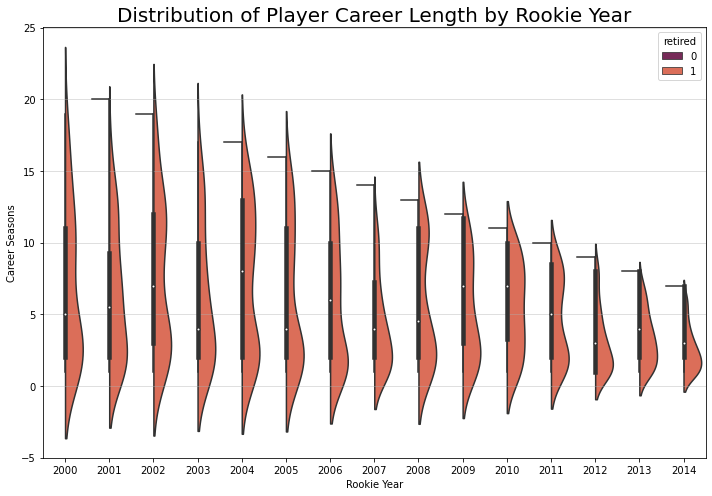

In [9]:
plt.figure(figsize=(10, 7))
sns.violinplot(data=df, x='yr1', y='yrs', hue='retired', split=True, palette='rocket')
plt.title('Distribution of Player Career Length by Rookie Year', size=20)
plt.xlabel('Rookie Year')
plt.ylabel('Career Seasons')
plt.grid(axis='y', alpha=.5)
plt.tight_layout()
plt.show()

The violin plot shows values below 0 to prevent any sharp curves, since many people retire after thev first season.

One thing that I found interesting about this plot is that on the right (the distribution of years played of the players that have retired), there seems to be a binodal distribution.  The sharp line on the left shows the current number of seasons played since they active players joined the NBA.  This bimodal distribution is likely first the players that were just not strong enough to last in the NBA, and the second is likely the players that started to get older and chose to retire.

The question of 'will an NBA rookie last 5 years in the NBA' does a decent job of falling between the two nodes.  One could argue that 7 would be better, but for the purposes of this project, we will work with 5.

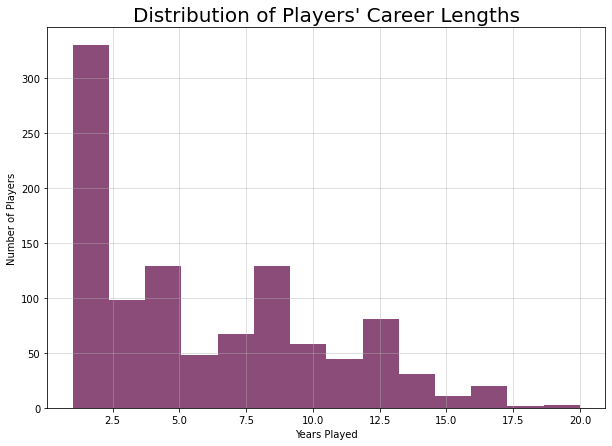

In [10]:
plt.figure(figsize=(10, 7))
sns.distplot(df['yrs'], kde=False, hist_kws={'alpha': .8, 'color': sns.color_palette('rocket')[1]})
plt.title("Distribution of Players' Career Lengths", size=20)
plt.xlabel('Years Played')
plt.ylabel('Number of Players')
plt.grid(alpha=.5)
plt.show()

In [11]:
X_train, X_val, y_train, y_val = train_test_split(df_prepped.drop('lasts', axis=1), df_prepped['lasts'], test_size=.4, random_state=56)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.5, random_state=92)

I'm doing this here to prevent data snooping.  I want to ensure that I don't introduce my own bias.  I did want to quickly look into the distributions to check for skewness.

In [12]:
rookies = X_train.merge(y_train, on=X_train.index).drop('key_0', axis=1).join(df['yrs'], on=X_train.index)
rookies.head()

,rk,player,debut,age,g,mp,fg_pct,threes_pct,ft_pct,fg_pm,...,orb_pm,trb_pm,ast_pm,stl_pm,blk_pm,tov_pm,pf_pm,pts_pm,lasts,yrs
0,74,Charlie Villanueva,1,21,81,2361,0.463,0.327,0.706,0.18424,...,0.07666,0.22067,0.03727,0.02541,0.02668,0.04193,0.10462,0.44600,True,11
1,47,Patrick Patterson,2,21,52,868,0.558,0.000,0.714,0.17166,...,0.09908,0.23041,0.04724,0.01959,0.04263,0.03571,0.08871,0.37788,True,10
2,72,Dijon Thompson,1,22,10,43,0.440,0.364,1.000,0.25581,...,0.09302,0.25581,0.02326,0.06977,0.02326,0.04651,0.13953,0.65116,False,2
3,32,Anthony Grundy,5,26,12,108,0.500,0.333,0.643,0.17593,...,0.00926,0.15741,0.08333,0.06481,0.00000,0.08333,0.12963,0.48148,False,1
4,52,Sasha Pavlović,0,20,79,1144,0.396,0.271,0.774,0.13024,...,0.03846,0.13899,0.05245,0.03584,0.01399,0.05857,0.16346,0.33392,True,10


In [13]:
rookies.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rk,630.0,36.703175,21.129230,1.0,19.000000,37.000000,54.000000,83.00000
debut,630.0,1.385714,1.504245,0.0,0.000000,1.000000,2.000000,6.00000
age,630.0,22.373016,2.048436,18.0,21.000000,22.000000,23.000000,31.00000
g,630.0,40.753968,26.321326,1.0,16.250000,38.000000,66.000000,82.00000
mp,630.0,701.779365,729.949571,0.0,130.500000,430.000000,1110.750000,3167.00000
fg_pct,630.0,0.406878,0.113747,0.0,0.364000,0.414500,0.460500,1.00000
threes_pct,630.0,0.186187,0.179924,0.0,0.000000,0.209500,0.333000,1.00000
ft_pct,630.0,0.632997,0.235666,0.0,0.571000,0.683000,0.773000,1.00000
fg_pm,630.0,0.124736,0.044421,0.0,0.100000,0.125000,0.152200,0.33333
threes_pm,630.0,0.017509,0.022393,0.0,0.000000,0.008320,0.029870,0.16000


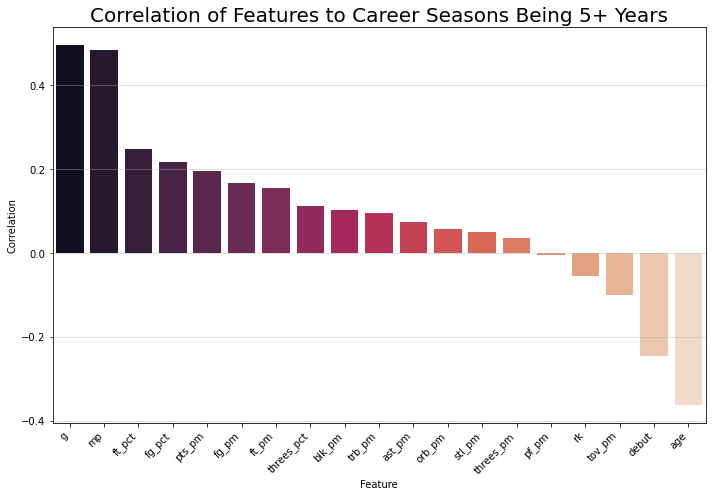

In [14]:
corrs = pd.DataFrame(rookies.corr()['lasts'].sort_values(ascending=False)).drop(['lasts', 'yrs'], axis=0).reset_index()

plt.figure(figsize=(10, 7))
sns.barplot(data=corrs, x='index', y='lasts', palette='rocket')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Correlation of Features to Career Seasons Being 5+ Years', size=20)
plt.ylabel('Correlation')
plt.xlabel('Feature')
plt.grid(axis='y', alpha=.5)
plt.tight_layout()
plt.show()

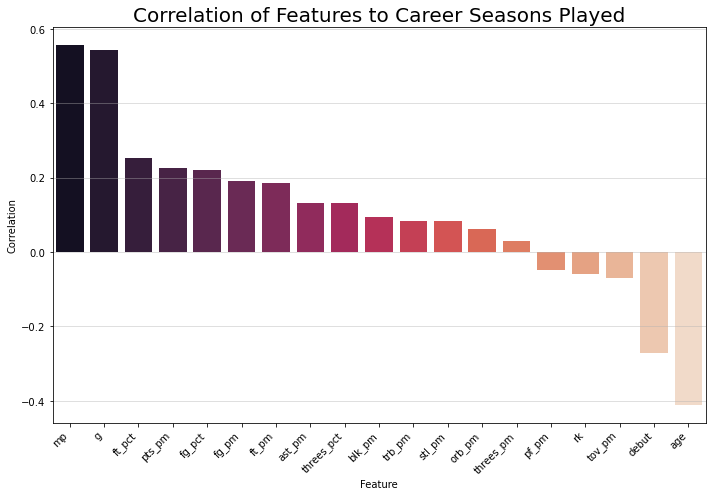

In [15]:
corrs = pd.DataFrame(rookies.corr()['yrs'].sort_values(ascending=False)).drop(['lasts', 'yrs'], axis=0).reset_index()

plt.figure(figsize=(10, 7))
sns.barplot(data=corrs, x='index', y='yrs', palette='rocket')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Correlation of Features to Career Seasons Played', size=20)
plt.ylabel('Correlation')
plt.xlabel('Feature')
plt.grid(axis='y', alpha=.5)
plt.tight_layout()
plt.show()

These two plots have some really interesting information:
- Firstly, we see a strong similarity between the correlations for both lasting at least 5 years and career length in general.
    - We also see that the career length in general correlations have stronger values than just if they last at least 5 years, which I believe is simply due to continuous (even though only ints) vs True/False
    - There are some differences, but they are all small changes (some have stronger correlations, the order of strength shifted some, but all are relatively in similar places between the two plots)
- A couple features have very weak correlations with if the player will last at least 5 years.
    - The player's rank has very little correlation with if the player will last at least 5 years.
        - This is not surprising, because this rank is based off of their performance in the NCAA, which is a totally different animal than the NBA.  Also, a team may have a specific need (position) at the moment that they're more interested in filling rather than just trying to get the very best player (any position).
    - The player's three point percentage is also a very weak correlator with the amount of time the player will stay in the NBA.
        - This makes sense because three pointers are the hardest shots to make, so the mentality for three pointers is more for when you can't get a closer shot.
        - Secondly, multiple positions on the court are not really supposed to be taking shots from beyond the arc.  Your forward should be under the net, so of course he won't be taking three pointers as often, and probably won't have as high a percentage as others who should be taking threes.
- There are no strong correlations, but many of these features have correlations that are meaningful.
    - If a player is playing a lot of games, this means that the team finds him valuable enough to be playing.  This of course would mean that the player is less likely to leave the NBA in less than 5 years.
        - This is the same logic for minutes played.
    - Points per minute, field goals per minute, free throws per minute, field goal percent, and free throw percent are all the actual skills (more deliverables) that would lead to extra game time.  These are all skills that all successful players should have.
        - Assists, blocks, and steals are also all actions that help the team win, and all players should try and do.
    - The negative correlation with age does not surprise me at all.  Players are considered old in the league at a very young age, so the younger you are the longer you can play before you are getting too 'old'
    - The negative correlation with debut makes sense, because if the player is debuted later in the season, this player is not performing well enough in practices to be put in.
    - Turnovers and personal fouls were both slightly negaitvely correlated with career length, which makes sense, since these are actions that help the other team (the other team gets possession and may get free throws).  I was surprised it wasn't more strongly correlated.
- I was surprised that the point productions was not more strongly correlated with career length.  This is a skill that is required of all players and is what drives the team to a win.  However, I guess that this makes sense since the team needs to pass the ball around and find an opening, and so other offensive skills such as assists are also important.  Ben Simmons is a good example of a player that is a very strong player, but isn't all that great at shooting.

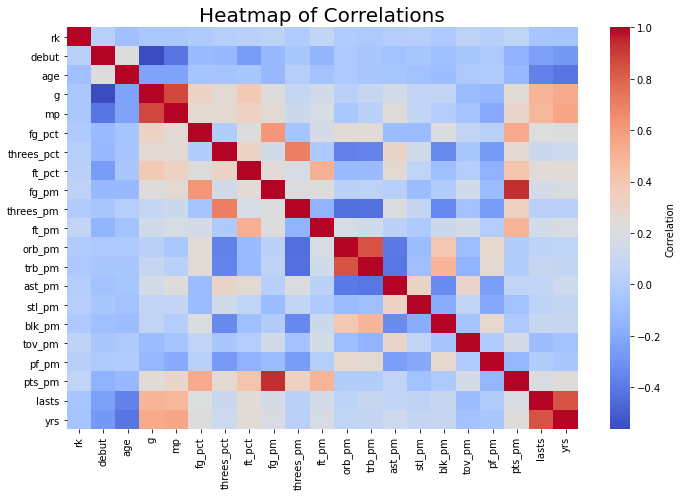

In [16]:
plt.figure(figsize=(10, 7))
sns.heatmap(rookies.corr(), cmap='coolwarm', cbar_kws={'label': 'Correlation'})
plt.title('Heatmap of Correlations', size=20)
plt.tight_layout()
plt.show()

This is just a visualization of all of the correlations between each feature.  Note the very high correlation of lasts and years.  This is of course the case because the label (lasts) is derived directly from the feature years (yrs >= 5)

In [17]:
num_per_end = int(rookies.shape[0]*.1)

most_time = rookies.nlargest(num_per_end, 'mp')
most_time['time'] = 'Top 10%'
least_time = rookies.nsmallest(num_per_end, 'mp')
least_time['time'] = 'Bottom 10%'
times_extreme = most_time.append(least_time)

num_per_end = int(rookies.shape[0]*.1)
most_games = rookies.nlargest(num_per_end, 'g')
most_games['time'] = 'Top 10%'
least_games = rookies.nsmallest(num_per_end, 'g')
least_games['time'] = 'Bottom 10%'
games_extreme = most_games.append(least_games)

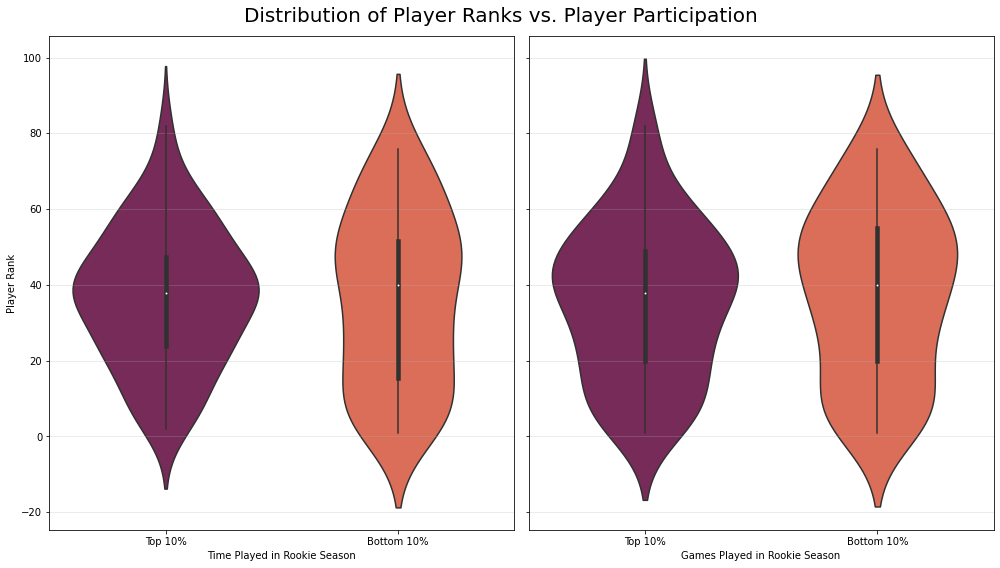

In [18]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14, 8))

sns.violinplot(data=times_extreme, x='time', y='rk', palette='rocket', ax=ax[0])
sns.violinplot(data=games_extreme, x='time', y='rk', palette='rocket', ax=ax[1])

fig.suptitle('Distribution of Player Ranks vs. Player Participation', size=20)
ax[0].set_ylabel('Player Rank')
ax[0].set_xlabel('Time Played in Rookie Season')
ax[0].grid(axis='y', alpha=.3)
ax[1].set_ylabel(None)
ax[1].set_xlabel('Games Played in Rookie Season')
ax[1].grid(axis='y', alpha=.3)

plt.tight_layout()
plt.show()

This is interesting to see, because we see that there really doesn't seem to be any sign that the player rank matters, when it comes to how much time the player will be playing.  This makes sense, since how they were ranked coming in really doesn't matter, since so few NCAA players are able to make it into the NBA anyways.  Also, the actual performance on the court should dictate the level of game time the player should get.

Another thing to note is that the best performers seem to be closer to a normal distribution of rank, while the worst performers seem to be more on the extremes of rank.  I think that this could be because, for the highest ranked players, there could be burnout or overconfidence, leading to less game time.  For the lowest ranked players, it may be because they just can't quite compete at the NBA level.

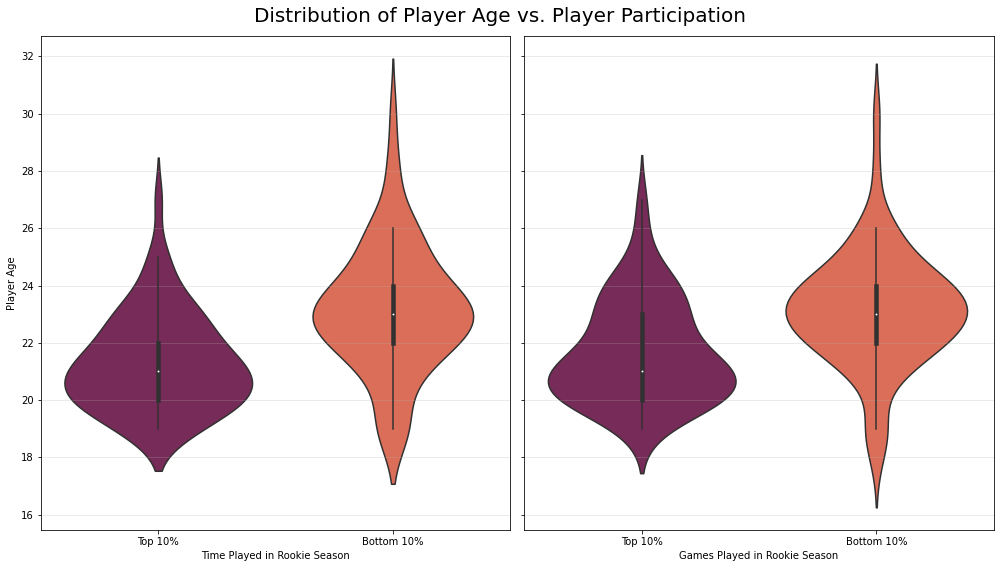

In [19]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14, 8))

sns.violinplot(data=times_extreme, x='time', y='age', palette='rocket', ax=ax[0])
sns.violinplot(data=games_extreme, x='time', y='age', palette='rocket', ax=ax[1])

fig.suptitle('Distribution of Player Age vs. Player Participation', size=20)
ax[0].set_ylabel('Player Age')
ax[0].set_xlabel('Time Played in Rookie Season')
ax[0].grid(axis='y', alpha=.3)
ax[1].set_ylabel(None)
ax[1].set_xlabel('Games Played in Rookie Season')
ax[1].grid(axis='y', alpha=.3)

plt.tight_layout()
plt.show()

This plot shows that the players that play the most are more likely to be the younger players.  This is possibly because the franchise sees the as a better investment, since they can play longer, or because they probably are players that just left the NCAA.  We also see from the previous two plots that the time played and games played have very similar results.  There seems to be two clusters in the top 10% of games played, and I believe that this could come back to the idea that the younger players are stronger investments for the team.  I think this because that split is only for number of games, so the idea that the younger player gets more time on the court makes sense, since they'd play longer.

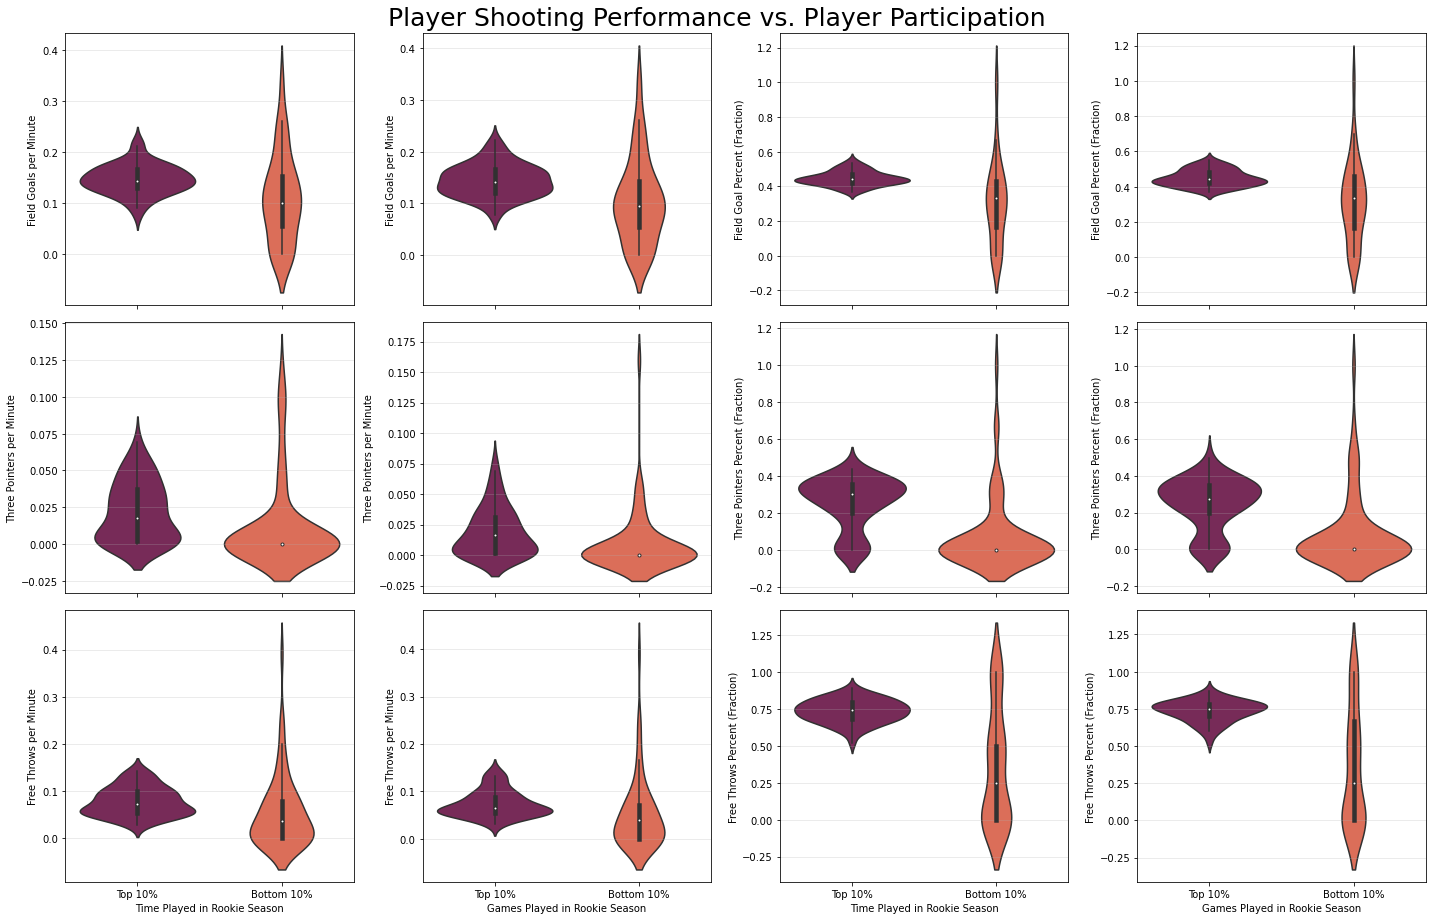

In [20]:
fig, ax = plt.subplots(3, 4, sharex=True, sharey=False, figsize=(20, 13))

sns.violinplot(data=times_extreme, x='time', y='fg_pm', palette='rocket', ax=ax[0][0])
sns.violinplot(data=games_extreme, x='time', y='fg_pm', palette='rocket', ax=ax[0][1])
sns.violinplot(data=times_extreme, x='time', y='fg_pct', palette='rocket', ax=ax[0][2])
sns.violinplot(data=games_extreme, x='time', y='fg_pct', palette='rocket', ax=ax[0][3])
sns.violinplot(data=times_extreme, x='time', y='threes_pm', palette='rocket', ax=ax[1][0])
sns.violinplot(data=games_extreme, x='time', y='threes_pm', palette='rocket', ax=ax[1][1])
sns.violinplot(data=times_extreme, x='time', y='threes_pct', palette='rocket', ax=ax[1][2])
sns.violinplot(data=games_extreme, x='time', y='threes_pct', palette='rocket', ax=ax[1][3])
sns.violinplot(data=times_extreme, x='time', y='ft_pm', palette='rocket', ax=ax[2][0])
sns.violinplot(data=games_extreme, x='time', y='ft_pm', palette='rocket', ax=ax[2][1])
sns.violinplot(data=times_extreme, x='time', y='ft_pct', palette='rocket', ax=ax[2][2])
sns.violinplot(data=games_extreme, x='time', y='ft_pct', palette='rocket', ax=ax[2][3])


fig.suptitle('Player Shooting Performance vs. Player Participation', size=25)
ax[0][0].set_ylabel('Field Goals per Minute')
ax[0][0].set_xlabel(None)
ax[0][0].grid(axis='y', alpha=.3)
ax[0][1].set_ylabel('Field Goals per Minute')
ax[0][1].set_xlabel(None)
ax[0][1].grid(axis='y', alpha=.3)
ax[0][2].set_ylabel('Field Goal Percent (Fraction)')
ax[0][2].set_xlabel(None)
ax[0][2].grid(axis='y', alpha=.3)
ax[0][3].set_ylabel('Field Goal Percent (Fraction)')
ax[0][3].set_xlabel(None)
ax[0][3].grid(axis='y', alpha=.3)
ax[1][0].set_ylabel('Three Pointers per Minute')
ax[1][0].set_xlabel(None)
ax[1][0].grid(axis='y', alpha=.3)
ax[1][1].set_ylabel('Three Pointers per Minute')
ax[1][1].set_xlabel(None)
ax[1][1].grid(axis='y', alpha=.3)
ax[1][2].set_ylabel('Three Pointers Percent (Fraction)')
ax[1][2].set_xlabel(None)
ax[1][2].grid(axis='y', alpha=.3)
ax[1][3].set_ylabel('Three Pointers Percent (Fraction)')
ax[1][3].set_xlabel(None)
ax[1][3].grid(axis='y', alpha=.3)
ax[2][0].set_ylabel('Free Throws per Minute')
ax[2][0].set_xlabel('Time Played in Rookie Season')
ax[2][0].grid(axis='y', alpha=.3)
ax[2][1].set_ylabel('Free Throws per Minute')
ax[2][1].set_xlabel('Games Played in Rookie Season')
ax[2][1].grid(axis='y', alpha=.3)
ax[2][2].set_ylabel('Free Throws Percent (Fraction)')
ax[2][2].set_xlabel('Time Played in Rookie Season')
ax[2][2].grid(axis='y', alpha=.3)
ax[2][3].set_ylabel('Free Throws Percent (Fraction)')
ax[2][3].set_xlabel('Games Played in Rookie Season')
ax[2][3].grid(axis='y', alpha=.3)

plt.tight_layout()
plt.show()

Here we see shooting performance differences between the players that play the most vs the players that play the least.  One thing that stands out is that the distribution on the bottom 10% is very large.  This is very likely due to the fact that they played so little, so they may not have had enough time to effectively settle into their performance values.  This means that the bottom 10% is likely filled with performance values that are not actually useful.

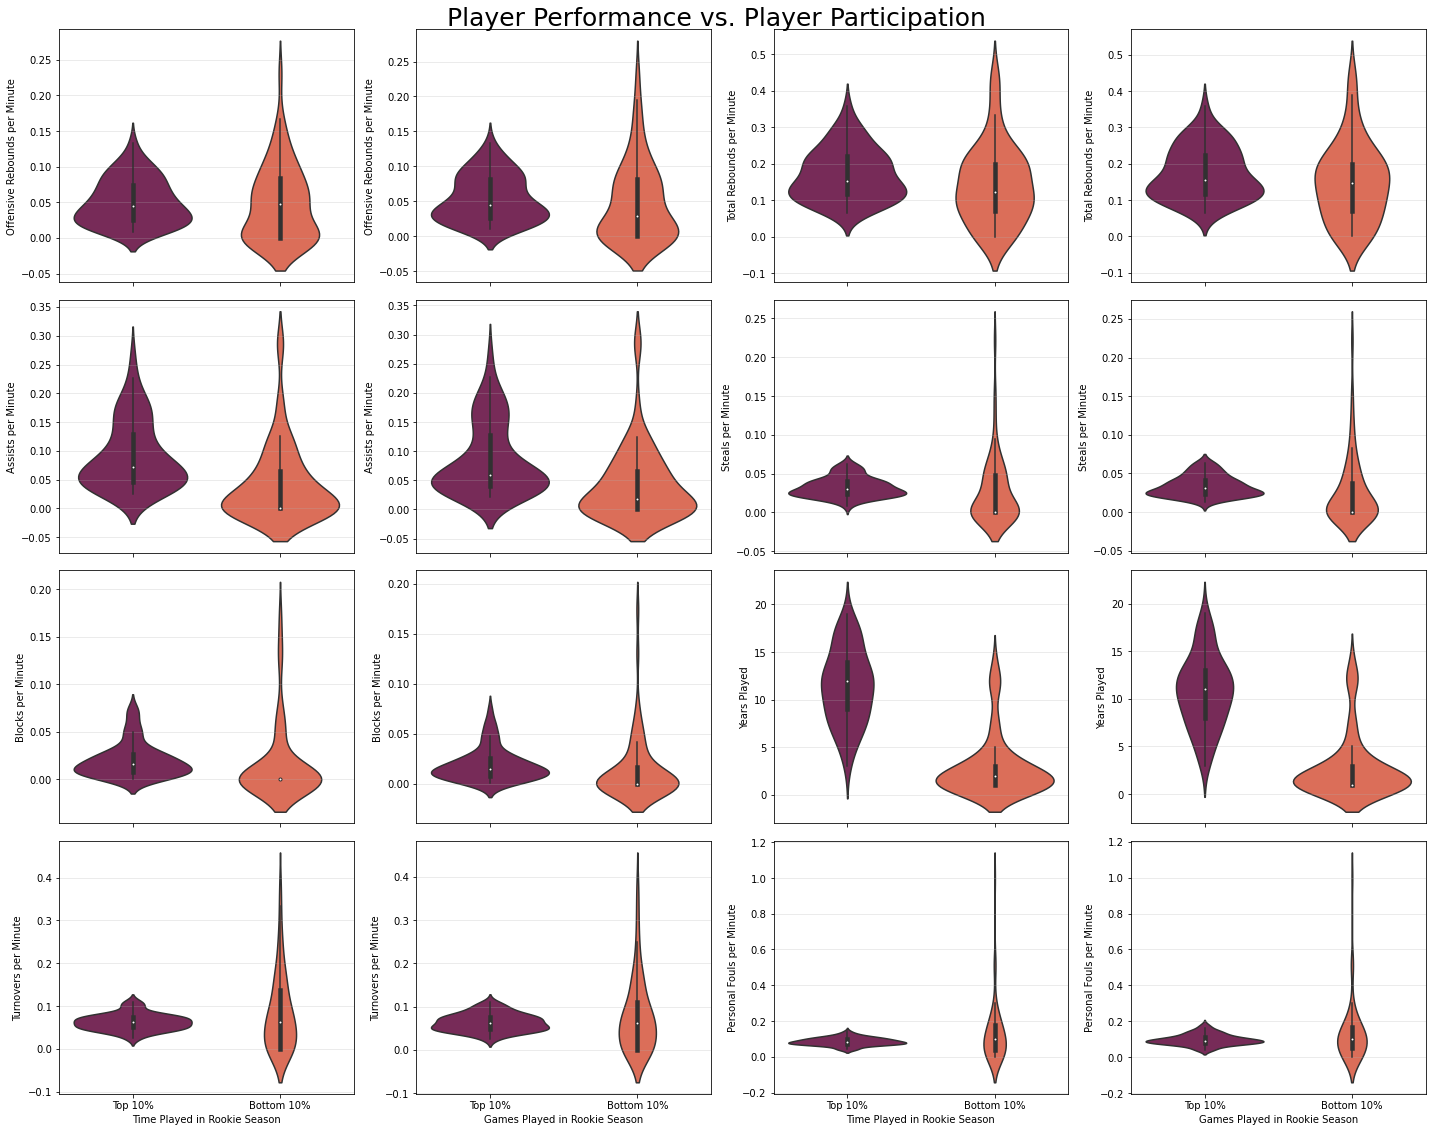

In [21]:
fig, ax = plt.subplots(4, 4, sharex=True, sharey=False, figsize=(20, 16))

sns.violinplot(data=times_extreme, x='time', y='orb_pm', palette='rocket', ax=ax[0][0])
sns.violinplot(data=games_extreme, x='time', y='orb_pm', palette='rocket', ax=ax[0][1])
sns.violinplot(data=times_extreme, x='time', y='trb_pm', palette='rocket', ax=ax[0][2])
sns.violinplot(data=games_extreme, x='time', y='trb_pm', palette='rocket', ax=ax[0][3])
sns.violinplot(data=times_extreme, x='time', y='ast_pm', palette='rocket', ax=ax[1][0])
sns.violinplot(data=games_extreme, x='time', y='ast_pm', palette='rocket', ax=ax[1][1])
sns.violinplot(data=times_extreme, x='time', y='stl_pm', palette='rocket', ax=ax[1][2])
sns.violinplot(data=games_extreme, x='time', y='stl_pm', palette='rocket', ax=ax[1][3])
sns.violinplot(data=times_extreme, x='time', y='blk_pm', palette='rocket', ax=ax[2][0])
sns.violinplot(data=games_extreme, x='time', y='blk_pm', palette='rocket', ax=ax[2][1])
sns.violinplot(data=times_extreme, x='time', y='yrs', palette='rocket', ax=ax[2][2])
sns.violinplot(data=games_extreme, x='time', y='yrs', palette='rocket', ax=ax[2][3])
sns.violinplot(data=times_extreme, x='time', y='tov_pm', palette='rocket', ax=ax[3][0])
sns.violinplot(data=games_extreme, x='time', y='tov_pm', palette='rocket', ax=ax[3][1])
sns.violinplot(data=times_extreme, x='time', y='pf_pm', palette='rocket', ax=ax[3][2])
sns.violinplot(data=games_extreme, x='time', y='pf_pm', palette='rocket', ax=ax[3][3])

fig.suptitle('Player Performance vs. Player Participation', size=25)
ax[0][0].set_ylabel('Offensive Rebounds per Minute')
ax[0][0].set_xlabel(None)
ax[0][0].grid(axis='y', alpha=.3)
ax[0][1].set_ylabel('Offensive Rebounds per Minute')
ax[0][1].set_xlabel(None)
ax[0][1].grid(axis='y', alpha=.3)
ax[0][2].set_ylabel('Total Rebounds per Minute')
ax[0][2].set_xlabel(None)
ax[0][2].grid(axis='y', alpha=.3)
ax[0][3].set_ylabel('Total Rebounds per Minute')
ax[0][3].set_xlabel(None)
ax[0][3].grid(axis='y', alpha=.3)
ax[1][0].set_ylabel('Assists per Minute')
ax[1][0].set_xlabel(None)
ax[1][0].grid(axis='y', alpha=.3)
ax[1][1].set_ylabel('Assists per Minute')
ax[1][1].set_xlabel(None)
ax[1][1].grid(axis='y', alpha=.3)
ax[1][2].set_ylabel('Steals per Minute')
ax[1][2].set_xlabel(None)
ax[1][2].grid(axis='y', alpha=.3)
ax[1][3].set_ylabel('Steals per Minute')
ax[1][3].set_xlabel(None)
ax[1][3].grid(axis='y', alpha=.3)
ax[2][0].set_ylabel('Blocks per Minute')
ax[2][0].set_xlabel(None)
ax[2][0].grid(axis='y', alpha=.3)
ax[2][1].set_ylabel('Blocks per Minute')
ax[2][1].set_xlabel(None)
ax[2][1].grid(axis='y', alpha=.3)
ax[2][2].set_ylabel('Years Played')
ax[2][2].set_xlabel(None)
ax[2][2].grid(axis='y', alpha=.3)
ax[2][3].set_ylabel('Years Played')
ax[2][3].set_xlabel(None)
ax[2][3].grid(axis='y', alpha=.3)
ax[3][0].set_ylabel('Turnovers per Minute')
ax[3][0].set_xlabel('Time Played in Rookie Season')
ax[3][0].grid(axis='y', alpha=.3)
ax[3][1].set_ylabel('Turnovers per Minute')
ax[3][1].set_xlabel('Games Played in Rookie Season')
ax[3][1].grid(axis='y', alpha=.3)
ax[3][2].set_ylabel('Personal Fouls per Minute')
ax[3][2].set_xlabel('Time Played in Rookie Season')
ax[3][2].grid(axis='y', alpha=.3)
ax[3][3].set_ylabel('Personal Fouls per Minute')
ax[3][3].set_xlabel('Games Played in Rookie Season')
ax[3][3].grid(axis='y', alpha=.3)

plt.tight_layout()
plt.show()

One thing that's very interesting is the distribution of years played between the players that played the most vs those that played the least.  The ones that played the most seemed normally distributed, while the ones that played the least for the most part had retired by the fifth season, and only a few players were able to make it to the average number of years played of the top performers.

We also see a similar situation where the players that played the least typically have a much wider distribution than the top performers.

For several of the performance metrics, there also seems to be two nodes for the top performers, which are probably the good players vs the featured players of the team.

In [22]:
rocket = sns.color_palette('rocket')
rocket_binary = [rocket[1], rocket[4]]

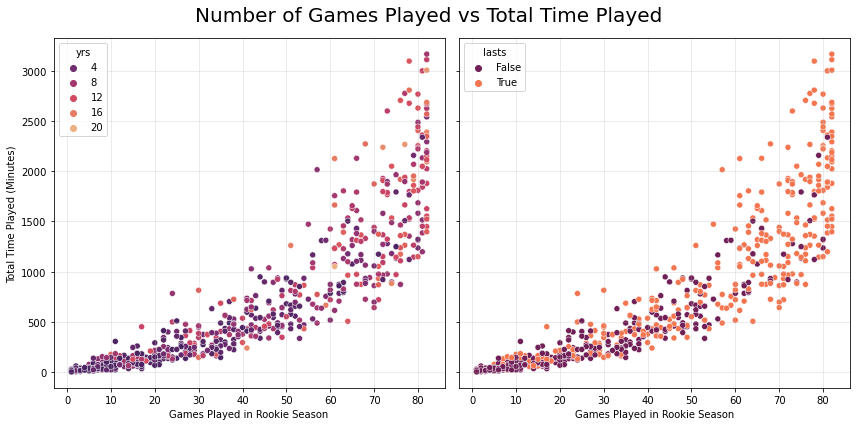

In [23]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))
sns.scatterplot(data=rookies, x='g', y='mp', hue='yrs', ax=ax[0], palette='flare_r')
sns.scatterplot(data=rookies, x='g', y='mp', hue='lasts', ax=ax[1], palette=rocket_binary)

fig.suptitle('Number of Games Played vs Total Time Played', size=20)
ax[0].set_ylabel('Total Time Played (Minutes)')
ax[0].set_xlabel('Games Played in Rookie Season')
ax[0].grid(alpha=.3)
ax[1].set_ylabel(None)
ax[1].set_xlabel('Games Played in Rookie Season')
ax[1].grid(alpha=.3)

plt.tight_layout()
plt.show()

This is interesting because we clearly see the line where players have hit the maximum number of games in the season.  We also see the trend of players playing more seasons in their career the more they play in their rookie season.

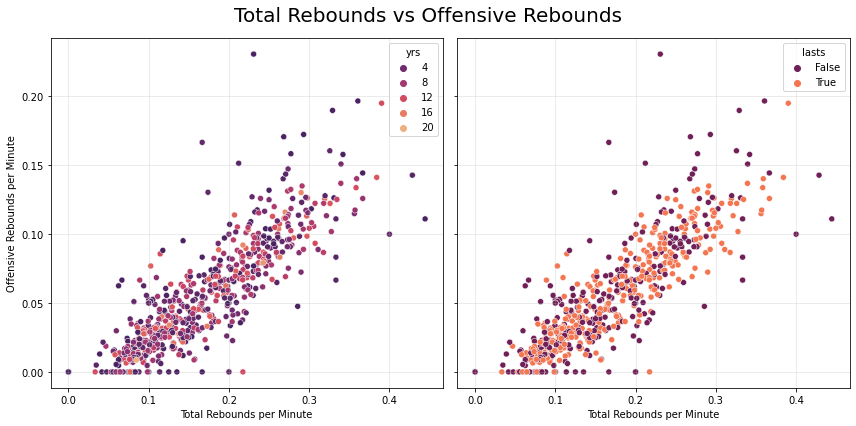

In [24]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))
sns.scatterplot(data=rookies, x='trb_pm', y='orb_pm', hue='yrs', ax=ax[0], palette='flare_r')
sns.scatterplot(data=rookies, x='trb_pm', y='orb_pm', hue='lasts', ax=ax[1], palette=rocket_binary)

fig.suptitle('Total Rebounds vs Offensive Rebounds', size=20)
ax[0].set_ylabel('Offensive Rebounds per Minute')
ax[0].set_xlabel('Total Rebounds per Minute')
ax[0].grid(alpha=.3)
ax[1].set_ylabel(None)
ax[1].set_xlabel('Total Rebounds per Minute')
ax[1].grid(alpha=.3)

plt.tight_layout()
plt.show()

This plot is interesting, because we see that there seems to be a strong correlation between total rebounds per minute and the offensive rebounds per minute.  This is to be expected, since offensive rebounds are within the total rebounds, but what's actually interesting about this is that there doesn't seem to be a preference between offensive and defensive rebounds.  I suppose this isn't surprising, since both are important, but I had expected players to tend to have more offensive rebounds or more defensive rebounds, not the same typically.  What we also see is that this doesn't seem to be significant when predicting career length.

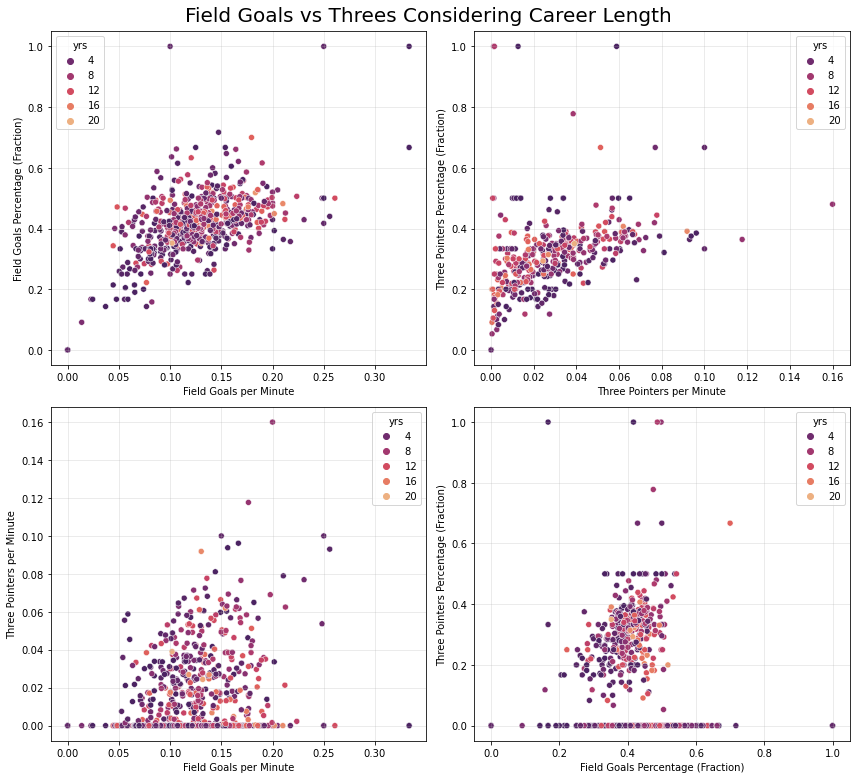

In [25]:
fig, ax = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(12, 11))
sns.scatterplot(data=rookies, x='fg_pm', y='fg_pct', hue='yrs', ax=ax[0][0], palette='flare_r')
sns.scatterplot(data=rookies, x='threes_pm', y='threes_pct', hue='yrs', ax=ax[0][1], palette='flare_r')
sns.scatterplot(data=rookies, x='fg_pm', y='threes_pm', hue='yrs', ax=ax[1][0], palette='flare_r')
sns.scatterplot(data=rookies, x='fg_pct', y='threes_pct', hue='yrs', ax=ax[1][1], palette='flare_r')

fig.suptitle('Field Goals vs Threes Considering Career Length', size=20)
ax[0][0].set_ylabel('Field Goals Percentage (Fraction)')
ax[0][0].set_xlabel('Field Goals per Minute')
ax[0][0].grid(alpha=.3)
ax[0][1].set_ylabel('Three Pointers Percentage (Fraction)')
ax[0][1].set_xlabel('Three Pointers per Minute')
ax[0][1].grid(alpha=.3)
ax[1][0].set_ylabel('Three Pointers per Minute')
ax[1][0].set_xlabel('Field Goals per Minute')
ax[1][0].grid(alpha=.3)
ax[1][1].set_ylabel('Three Pointers Percentage (Fraction)')
ax[1][1].set_xlabel('Field Goals Percentage (Fraction)')
ax[1][1].grid(alpha=.3)

plt.tight_layout()
plt.show()

When looking at three pointers, we see that a lot of people don't take any threes, and also many many people aren't making any threes.  There are also lines are 0.5 and 1, which are players with very few shots taken, and either made 1 out of 2, or made the one or two shots that they took.

We also see no real correlation between field goal percentage vs three pointer percentage, but we do see that the field goal percentage is higher than the three pointer percentage.  This makes sense, since field gols are shots taken closer to the basket than three pointers sand so are easier to make.  Additionally, we see that there is a much higher rate of making field goals than three pointers, which makes sense for the same reason as the percentages.

We also see that there is a positive trend between taking more shots per minute and a higher shooting percentage.  This is because the better they are at shooting, the more baskets they'll make.